# 2-level system
Illustrating how to use the `toy_systems` package by simulating a closed two level system. 

## Imports
Start by importing the necessary packages:

In [15]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import qutip
from sympy import Symbol

from toy_systems.couplings import ToyCoupling, ToyEnergy
from toy_systems.decays import Decay
from toy_systems.hamiltonian import Hamiltonian
from toy_systems.states import Basis, BasisState, ToyQuantumNumbers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Rabi oscillations
In Rabi oscillations the probability of being in each state flip-flops between the two states of the system sinusoidally in time. Rabi oscillations occur when the two levels are coupled by a driving field at a constant detuning from the natural frequency, and here we are also assuming a constant amplitude for the driving field.

I'm defining the system in the rotating frame so that the Hamiltonian is time-independent

### Define states
We start by defining the two states of the system: the ground state $|g\rangle$ and the excited $|e\rangle$, which we will later set to have a decay path to $|g\rangle$:

In [16]:
g = BasisState(qn=ToyQuantumNumbers(label="g"))
e = BasisState(qn=ToyQuantumNumbers(label="e"))

# Print the states as a check
print(f"|g> = {g}")
print(f"|e> = {e}")

# Check that the states are orthogonal by taking inner product
print(f"<e|g> = {e @ g}")

|g> = |g>
|e> = |e>
<e|g> = 0


### Define basis
We use the two orthogonal states to define a basis as shown below. The indexing of the matrix and vector representations of operators is determined by the order of the states when generating the state

In [17]:
basis = Basis((g,e))
basis.print_basis()

|0> = |g>
|1> = |e>


### Define energies
I'm going to define the system in the rotating frame so that the Hamiltonian is time independent. The detuning between the driving field and the natural frequency of the system is taken to be $\Delta$, so I can set the energies of the two states to be $E_g = -\Delta/2$ and $E_e = \Delta/2$:

In [18]:
Δ = Symbol('Delta') # Using sympy to generate a symbolic Hamiltonian first
E_g = ToyEnergy(g, g, -Δ/2)
E_e = ToyEnergy(e, e, +Δ/2)

### Define coupling
The coupling is defined to have a constant magnitude and since we're in the rotating frame, there is no time dependence.

In [19]:
Ω = Symbol('Omega')
coupling = ToyCoupling(g, e, Ω)

### Define Hamiltonian
Now that we have the states, energies and couplings, we can define the Hamiltonian

In [20]:
H = Hamiltonian(basis, (E_g, E_e, coupling))
display(H)

H =
[
[        -Delta/2,   Omega],
[conjugate(Omega), Delta/2]]

in basis Basis: name = None

### Define decay matrix from |e> to |g>
Can add a spontaneous decay from the excited state to the ground state as shown below:

In [21]:
decay = Decay(e, g, Symbol("Gamma"))
decay.generate_decay_matrix(basis)
decay.generate_qobj(gamma = 1)

### Time-evolution using `QuTiP`
The `toy_systems` package is designed to take care of generating the Hamiltonian and collapse operators for the quantum system, and spit out a `qutip.QobjEVo`-object. The actual time-evolution is then taken care of by `qutip` (or something else if the user so desires).



In [22]:
psi0 = (1*g).qobj(basis) # Initial state
P_g_op = qutip.Qobj((1*g).density_matrix(basis), type = "oper")
P_e_op = qutip.Qobj((1*e).density_matrix(basis), type = "oper")

# Set the parameters for the system
H.qobj.args["Delta"] = 0
H.qobj.args["Omega"] = 1

times = np.linspace(0,10,1001) # Times at which result is requested
result = qutip.mesolve(H.qobj, psi0, times, c_ops = decay.qobj(0), e_ops = [P_g_op, P_e_op])

Plot the result:

Text(0, 0.5, 'Population in each state')

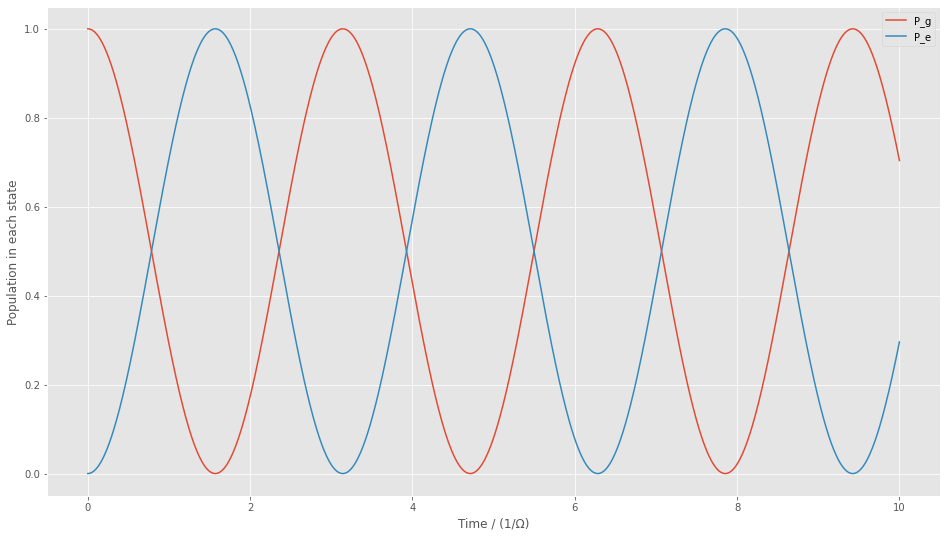

In [23]:
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(times, result.expect[0], label = "P_g")
ax.plot(times, result.expect[1], label = "P_e")
ax.legend()
ax.set_xlabel("Time / (1/Ω)")
ax.set_ylabel("Population in each state")

We can repeat the simulation with a different value of detuning by changing the `args` of `H.qobj`:

In [24]:
H_new = H.copy()
H_new.qobj.args["Delta"] = 0
H_new.qobj.args["Omega"] = 1

Text(0, 0.5, 'Population in each state')

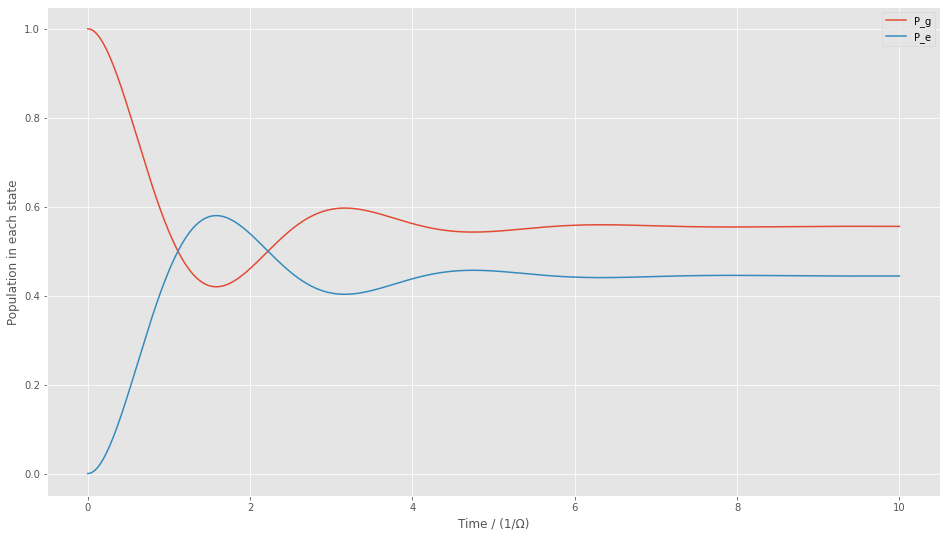

In [25]:
result = qutip.mesolve(H_new.qobj, psi0, times, c_ops = decay.qobj(1), e_ops = [P_g_op, P_e_op])

fig, ax = plt.subplots(figsize = (16,9))
ax.plot(times, result.expect[0], label = "P_g")
ax.plot(times, result.expect[1], label = "P_e")
ax.legend()
ax.set_xlabel("Time / (1/Ω)")
ax.set_ylabel("Population in each state")